# CR.CA.StatisticsMaps.Master.ipynb
## Statistical analysis over CA study area (+ further refining of ground obs)
### Karl Lapo July/2015

#### To do list
- Clean up data processing (move processing of grobs to separate script)
- Clean up functions
- Remake map

In [6]:
####################################################################################################
# CR.CA.StatisticsMaps.Master.ipynb
# Karl Lapo July/2015
####################################################################################################
# statistical analysis over CA study area + further refining of ground obs
#################################################################################################### 

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## FLAGS for processing
flag_getdata = 0              # Load and process raw data (1)? Or load pre-processed data (0)?

## Import statements
# netcdf/numpy/xray
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
import numpy as np
from datetime import datetime, timedelta
import pickle
import pandas as pd
import xray

# OS interaction
import sys
import os

# solargeometry
import solargeo

# import subplots function for plotting
import seaborn as sns
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import matplotlib

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_MODIS = '/MODIS.IRRAD'

In [2]:
####################################################################################################
# Functions
####################################################################################################

In [3]:
##### Discrete colorbar -- from Joe Hamman (https://github.com/jhamman/tonic/blob/master/tonic/plot_utils.py#L66-L94)
def cmap_discretize(cmap, n_colors=10):
    """Return discretized colormap.
    Parameters
    ----------
    cmap : str or colormap object
        Colormap to discretize.
    n_colors : int
        Number of discrete colors to divide `cmap` into.
    Returns
    ----------
    disc_cmap : LinearSegmentedColormap
        Discretized colormap.
    """
    import matplotlib
    try:
        cmap = cm.get_cmap(cmap)
    except:
        cmap = cm.get_cmap(eval(cmap))
    colors_i = np.concatenate((np.linspace(0, 1., n_colors), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., n_colors + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki])
                      for i in range(n_colors + 1)]

    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % n_colors,
                                              cdict, 1024)

In [4]:
##### Basemap
def build_basemap(lon,lat,dir_bmap,bmap_name='basemap.pickle',rewrite=False):
    # Lat/Lon handling - map extent
    bmap_dict = {}
    bmap_dict['lat_i'] = np.min(lat)
    bmap_dict['lon_i'] = np.min(lon)
    bmap_dict['lat_j'] = np.max(lat)
    bmap_dict['lon_j'] = np.max(lon)
    
    bmap_dict['lat_mid'] = lat[np.round(lat.size/2)]
    bmap_dict['lon_mid'] = lon[np.round(lon.size/2)]
    
    bmap_dict['lat_labels'] = np.arange(np.round(bmap_dict['lat_i']), np.round(bmap_dict['lat_j']), 2)
    bmap_dict['lon_labels'] = np.arange(np.round(bmap_dict['lon_i']), np.round(bmap_dict['lon_j']), 2)
    
    os.chdir(dir_bmap)
    # Force rewriting basemap pickle file
    if rewrite:
        bmap = Basemap(llcrnrlon=bmap_dict['lon_i'],llcrnrlat=bmap_dict['lat_i'],\
                        urcrnrlon=bmap_dict['lon_j'],urcrnrlat=bmap_dict['lat_j'],\
                        rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',\
                        lat_1=bmap_dict['lat_mid'],lon_0=bmap_dict['lon_mid'])
        pickle.dump(bmap,open(bmap_name,'wb'),-1)
    
    else:
        try:
            bmap = pickle.load(open(bmap_name,'rb'))
        except IOError as e:
            bmap = Basemap(llcrnrlon=bmap_dict['lon_i'],llcrnrlat=bmap_dict['lat_i'],\
                            urcrnrlon=bmap_dict['lon_j'],urcrnrlat=bmap_dict['lat_j'],\
                            rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',\
                            lat_1=bmap_dict['lat_mid'],lon_0=bmap_dict['lon_mid'])
            pickle.dump(bmap,open(bmap_name,'wb'),-1)
    
    return bmap,bmap_dict

In [5]:
####################################
## Read previously processed data ##
####################################
# ///// numpy/netcdf ad hoc method - notes do not indicate why I did this when the xray method works. 
# ///// See non-master version of script for previous method

# Load netcdfs to xray dataset objects
if flag_getdata:
    ###########
    ## NLDAS ##
    print('Loading NLDAS...')
    # Load
    os.chdir(dir_data+dir_NLDAS)
    nldas = xray.open_dataset('CA.NLDAS.irrad.v2_sorted.nc', chunks={'time': 365})
    
    # Resample
    nldas_day = nldas.resample(freq='D', dim='time', how='mean')
    nldas_month = nldas.resample(freq='M', dim='time', how='mean')
    
    # Save
    nldas_day.to_netcdf('CA.NLDAS.irrad.daily.nc')
    nldas_month.to_netcdf('CA.NLDAS.irrad.monthly.nc')
    
    #######################
    ## CERES SYN Product ##
    print('Loading CERES SYN...')
    # Load
    os.chdir(dir_data+dir_SYN)
    syn = xray.open_dataset('CA.SYN.irrad.nc', chunks={'time': 365})

    # Resample
    syn_day = syn.resample(freq='D', dim='time', how='mean')
    syn_month = syn.resample(freq='M', dim='time', how='mean')

    # Save
    syn_day.to_netcdf('CA.SYN.irrad.daily.nc')
    syn_month.to_netcdf('CA.SYN.irrad.monthly.nc')
    
    ################################################
    ## VIC/MTCLIM met preprocessor w/ Livneh data ##
    print('Loading MTCLIM...')
    # Load
    os.chdir(dir_data+dir_VIC)
    mtclim = xray.open_dataset('CA.MTCLIM.irrad.nc', chunks={'time': 365})
    
    # Resample
    mtclim_day = mtclim.resample(freq='D', dim='time', how='mean')
    mtclim_month = mtclim.resample(freq='M', dim='time', how='mean')

    # Save
    mtclim_day.to_netcdf('CA.MTCLIM.irrad.daily.nc')
    mtclim_month.to_netcdf('CA.MTCLIM.irrad.monthly.nc')
    
    ###########
    ## MODIS ##
#     print('Loading MODIS...')
#     # Load
#     os.chdir(dir_data+dir_MODIS)
#     modis = xray.open_dataset('CA.MODIS.interp_shortwave_hour.nc', chunks={'time': 365})
#     print(modis)
    
#     # Resample
#     modis_day = modis.resample(freq='D', dim='time', how='mean')
#     modis_month = modis.resample(freq='M', dim='time', how='mean')
    
#     # Save
#     modis_day.to_netcdf('CA.MODIS.irrad.daily.nc')
#     modis_month.to_netcdf('CA.MODIS.irrad.monthly.nc')
    
    ########################################
    ## Ground Observations (CIMIS + CDWR) ##
    print('Loading surface observations...')
    os.chdir(dir_data+dir_grobs)
    grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
    
    ## Resample, exclude months w/ > 10% gaps
    grobs_day = grobs.resample(freq='D', dim='time', how='mean')
    grobs_day.SWdwn.values[grobs_day.SWdwn.values == 0] = np.nan
    numdays_permonth = (~np.isnan(grobs_day['SWdwn'])).resample(freq='M', dim='time', how='mean')
    grobs_month = grobs_day.resample(freq='M', dim='time', how='mean')
    grobs_month.SWdwn.values[numdays_permonth.values < .9] = np.nan

    ## Remove stations outside study domain
    # Bounding box - ragged domain
    LL_rag = [-120,34.5]
    LR_rag = [-115,34.5]
    UR_rag = [-118.5,41]
    UL_rag = [-123.5,41]
    
    # Station lat/lon
    stat_lat = grobs_month.lat.values
    stat_lon = -grobs_month.lon.values
    
    # Ragged domain, CA study area
    line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
    line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
    line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
    line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
    ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                    (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                    (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))
    # Reindex
    stat_to_keep = ds.station[ind]
    grobs_month = grobs_month.reindex(station=stat_to_keep)
    
    ## Append station group information
    # Station data excel speadsheet
    stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                    index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
    # station data -> xray structure
    stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                                 'Grouping': (['station'],  stdat.Grouping)})    
    # Merge into ground observation structure
    grobs_month = grobs_month.merge(stdat,join='inner')
    
    ## Save
    grobs_day.to_netcdf('CA.grobs.irrad.daily.nc')
    grobs_month.to_netcdf('CA.grobs.irrad.monthly.nc')
    
else:
    ## Load
    os.chdir(dir_data+dir_NLDAS)
    nldas = xray.open_dataset('CA.NLDAS.irrad.monthly.nc')
    nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})
    
    os.chdir(dir_data+dir_SYN)
    syn = xray.open_dataset('CA.syn.irrad.monthly.nc')
    syn.longitude.values = syn.longitude.values-360
    syn.latitude.values = syn.latitude.values[::-1]
    
    os.chdir(dir_data+dir_VIC)
    mtclim = xray.open_dataset('CA.MTCLIM.irrad.monthly.nc')
    
    os.chdir(dir_data+dir_grobs)
    grobs = xray.open_dataset('CA.grobs.irrad.monthly.nc')
    grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
    grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
    grobs.longitude.values = -grobs.longitude.values

# ----------------------- DO NOT RUN BELOW CODE -----------------------

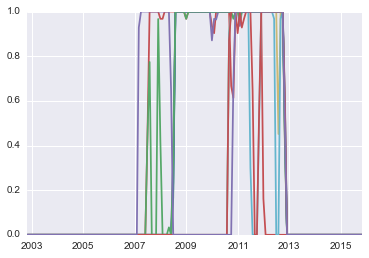

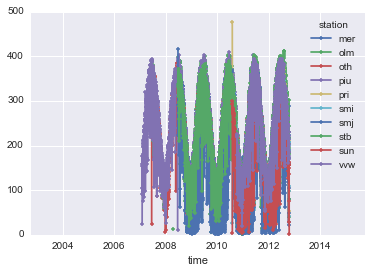

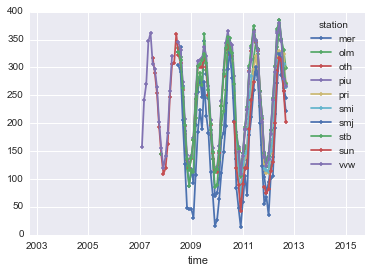

In [48]:
## Protoyping code for removing months with too little data (more than 10% gaps)
os.chdir(dir_data+dir_grobs)
grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
grobs_day = grobs.resample(freq='D', dim='time', how='mean')
grobs_day.SWdwn.values[grobs_day.SWdwn.values == 0] = np.nan
numdays_permonth = (~np.isnan(grobs_day['SWdwn'])).resample(freq='M', dim='time', how='mean')
grobs_month = grobs_day.resample(freq='M', dim='time', how='mean')
grobs_month.SWdwn.values[numdays_permonth.values < .9] = np.nan

plt.figure()
plt.plot(numdays_permonth.time,numdays_permonth.values[:,-10:])

plt.figure()
grobs_day.SWdwn[:,-10:].to_pandas().plot(marker='.')
plt.figure()
grobs_month.SWdwn[:,-10:].to_pandas().plot(marker='.')

## Save new monthly observed value xray structure
# grobs_day.to_netcdf('CA.grobs.irrad.daily.nc')
# grobs_month.to_netcdf('CA.grobs.irrad.monthly.nc')

RuntimeError: NetCDF: Can't add HDF5 file metadata

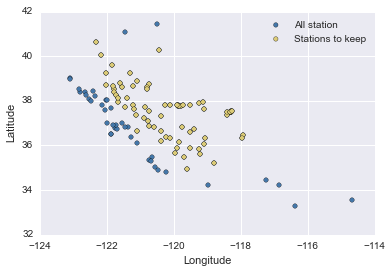

In [49]:
## Prototyping code for removing coastal stations outside domain
# Bounding box - ragged domain
LL_rag = [-120,34.5]
LR_rag = [-115,34.5]
UR_rag = [-118.5,41]
UL_rag = [-123.5,41]

# Station lat/lon
stat_lat = grobs_month.lat.values
stat_lon = -grobs_month.lon.values

# Ragged domain, CA study area
line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))

colsche =   np.array([[68.,119.,170.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

plt.scatter(-grobs_month.lon,grobs_month.lat,c=colsche[0,:],label='All station')
plt.scatter(-grobs_month.lon[ind],grobs_month.lat[ind],c=colsche[1,:],label='Stations to keep')
plt.legend()
plt.ylabel('Latitude')
plt.xlabel('Longitude')

stat_to_keep = grobs_month.station[ind]
grobs_month = grobs_month.reindex(station=stat_to_keep)

## Save new monthly observed value xray structure
# grobs_day.to_netcdf('CA.grobs.irrad.daily.nc')
# grobs_month.to_netcdf('CA.grobs.irrad.monthly.nc')

In [51]:
## Appending station classification
os.chdir(dir_data+dir_grobs)
# Station data excel speadsheet
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
# station data -> xray structure
stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                             'Grouping': (['station'],  stdat.Grouping)})

# Merge into ground observation structure
grobs_month = grobs_month.merge(stdat,join='inner')

# Save to netcdf
# grobs_month.to_netcdf('CA.grobs.irrad.monthly.nc')

# ----------------------- DO NOT RUN ABOVE CODE -----------------------

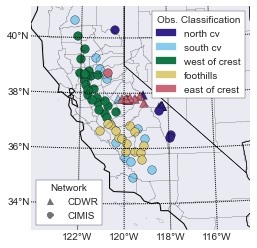

In [6]:
#### Descriptive Maps of Ground Observation Stations
## Plot station distribution
f = plt.figure(figsize=(4, 4))

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

# Build basemap
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

bmp,bmd = build_basemap(lon_stat,lat_stat,dir_bmap,'CA.Domain.bmp.pickle')
lat_labels = np.arange(34,42,2)
lon_labels = np.arange(-116.,-124.,-2)

# Colors
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)
for n,gr in enumerate(grobs.groupby('Grouping')):
    if 'CDWR' in gr[1].swap_dims({'station':'network'}).network.values:
        ds_plot = gr[1].swap_dims({'station':'network'}).loc[{'network':'CDWR'}]
        bmp.scatter(ds_plot.longitude.values,ds_plot.latitude.values,\
                    marker='^',c=colsche[n,:],s=75,label=gr[0],latlon=True)
    
    if 'CIMIS_IPM' in gr[1].swap_dims({'station':'network'}).network.values:
        ds_plot = gr[1].swap_dims({'station':'network'}).loc[{'network':'CIMIS_IPM'}]
        bmp.scatter(ds_plot.longitude.values,ds_plot.latitude.values,\
                    marker='o',c=colsche[n,:],s=75,label=gr[0],latlon=True)
    
## Format -- map properties
bmp.drawparallels(lat_labels,labels=[1,0,0,0])
bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 

# political boundaries.
bmp.drawstates()
bmp.drawcoastlines()
bmp.drawcounties()

## Format -- legend properties
# Group classification -- colors
grouping = ['north cv','south cv','west of crest','foothills','east of crest']
h1 = [matplotlib.patches.Patch(color=colsche[n,:], label=gr) \
          for n,gr in enumerate(grouping)]
leg = plt.legend(handles=h1,frameon=True)
leg.set_title('Obs. Classification')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(leg)

# Network type -- shapes
import matplotlib.lines as mlines
markertype = ['^','o']
label = ['CDWR','CIMIS']
gray_color = np.divide(np.array([115.,115.,115.]),256.)
h2 = [mlines.Line2D([],[],marker=mt,color=gray_color, label=lab, linestyle='none') \
          for mt,lab in zip(markertype,label)]
leg = plt.legend(handles=h2,frameon=True,loc=3)
leg.set_title('Network')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')

# Print
os.chdir(dir_print)
fname = 'GrObs.Groups.png'
f.savefig(fname)

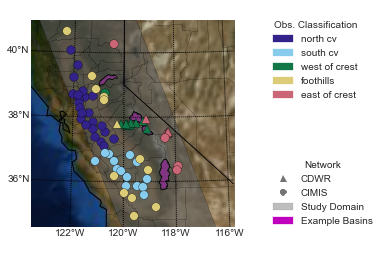

In [8]:
#### Descriptive Maps of Ground Observation Stations
## Plot station distribution
f = plt.figure(figsize=(6, 4))
gs = matplotlib.gridspec.GridSpec(1,2,width_ratios=(1,.5))

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

## Build basemap
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

bmp,bmd = build_basemap(lon_stat,lat_stat,dir_bmap,'CA.Domain.bmp.pickle')
lat_labels = np.arange(34,42,2)
lon_labels = np.arange(-116.,-124.,-2)

## Colors
import kgraph
ax = plt.subplot(gs[0,0])
colsche = kgraph.SRON(5)

## Study domain shape
bmp.bluemarble()
# lats = [34.5,34.5,41,41]
# lons = [-120,-115,-118,-123.5]
lats = [34.5,34.5,41,41]
lons = [-120,-116.5,-119.5,-123.5]
x, y = bmp( lons, lats )
xy = zip(x,y)
ax.add_patch(matplotlib.patches.Polygon(xy, closed=True,\
                    facecolor=np.divide(np.array([90.,90.,90.]),256.),alpha=.6))
grouping = ['north cv','south cv','west of crest','foothills','east of crest']
grobs_map_plot = grobs.swap_dims({'station':'Grouping'})

## Basin shapefiles
os.chdir(dir_bmap+'/BasinShapefiles')
bmp.readshapefile('./SierraBasins', 'SierraBasins')
patches   = []

for info, shape in zip(bmp.SierraBasins_info, bmp.SierraBasins):
    patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, facecolor= 'm', edgecolor='k', linewidths=1.))

## Station scatter map
for n,gr in enumerate(grouping):
    if 'CDWR' in grobs_map_plot.loc[{'Grouping':gr}].network.values:
        ds_plot = grobs_map_plot.loc[{'Grouping':gr}].swap_dims({'Grouping':'network'}).loc[{'network':'CDWR'}]
        bmp.scatter(ds_plot.longitude.values,ds_plot.latitude.values,\
                    marker='^',c=colsche[n,:],s=75,label=gr[0],latlon=True,zorder=10)
    
    if 'CIMIS_IPM' in grobs_map_plot.loc[{'Grouping':gr}].network.values:
        ds_plot = grobs_map_plot.loc[{'Grouping':gr}].swap_dims({'Grouping':'network'}).loc[{'network':'CIMIS_IPM'}]
        bmp.scatter(ds_plot.longitude.values,ds_plot.latitude.values,\
                    marker='o',c=colsche[n,:],s=75,label=gr[0],latlon=True,zorder=10)

## Format -- map properties
bmp.drawparallels(lat_labels,labels=[1,0,0,0])
bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 

# political boundaries.
bmp.drawstates()
bmp.drawcoastlines()
bmp.drawcounties()

## Format -- legend properties
# Legend axis
ax = plt.subplot(gs[0,1])
ax.axis('off')

# Group classification -- colors
grouping = ['north cv','south cv','west of crest','foothills','east of crest']
h1 = [matplotlib.patches.Patch(color=colsche[n,:], label=gr) \
          for n,gr in enumerate(grouping)]
leg = plt.legend(handles=h1,loc='upper left')
leg.set_title('Obs. Classification')
# leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(leg)

# Network type -- shapes
import matplotlib.lines as mlines
markertype = ['^','o']
label = ['CDWR','CIMIS']
gray_color = np.divide(np.array([115.,115.,115.]),256.)
h2 = [mlines.Line2D([],[],marker=mt,color=gray_color, label=lab, linestyle='none') \
            for mt,lab in zip(markertype,label)]
h2.append(matplotlib.patches.Patch(color=np.divide(np.array([90.,90.,90.]),256.),\
            alpha=.4,label='Study Domain'))
h2.append(matplotlib.patches.Patch(color='m',label='Example Basins'))
leg = plt.legend(handles=h2,loc='lower left')
leg.set_title('Network')
leg.get_frame().set_facecolor('w')


## Print
os.chdir(dir_print)
fname = 'GrObs.Groups.png'
f.savefig(fname)

#### Revising study domain?
- narrowing study domain focuses study domain on selected ground observation sites
- limis influence of Great Basin meteorology on the study statistics
- Fits study domain on map extent :p

Previous lat/lon: 
lats = [34.5,34.5,41,41]
lons = [-120,-115,-118,-123.5]

In [31]:
###############################
## Climatology and Anomalies ##
###############################
def mon_clim(xray_df):
    # Monthly climatology values
    df_cl = xray_df.groupby('time.month').mean('time')
    # Monthly anomaly maps
    df_anom = xray_df.groupby('time.month')-df_cl

    # Return values
    return(df_cl,df_anom)

monthly_cl = {}
monthly_anom = {}
monthly_mean = {}
monthly_cl['syn'],monthly_anom['syn'] = mon_clim(syn)
monthly_cl['nldas'],monthly_anom['nldas'] = mon_clim(nldas)
monthly_cl['mtclim'],monthly_anom['mtclim'] = mon_clim(mtclim)
monthly_cl['grobs'],monthly_anom['grobs'] = mon_clim(grobs)

monthly_mean['syn'] = syn
monthly_mean['nldas'] = nldas
monthly_mean['mtclim'] = mtclim
monthly_mean['grobs'] = grobs

print(monthly_mean)

{'grobs': <xray.Dataset>
Dimensions:    (station: 73, time: 157)
Coordinates:
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
  * station    (station) |S19 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
  * time       (time) datetime64[ns] 2002-10-31 2002-11-30 2002-12-31 ...
    Grouping   (station) |S13 'south cv' 'foothills' 'foothills' ...
Data variables:
    SWdwn      (time, station) float64 nan nan nan nan nan nan nan nan nan ..., 'syn': <xray.Dataset>
Dimensions:        (latitude: 8, longitude: 9, time: 143)
Coordinates:
  * longitude      (longitude) float32 -483.5 -482.5 -481.5 -480.5 -479.5 ...
  * time           (time) datetime64[ns] 2002-07-31 2002-08-31 2002-09-30 ...
  * latitude       (latitude) float32 41.4987

In [ ]:
##############################
## Monthly climatology maps ##
##############################
SWmin = 80
SWmax = 360
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# rad_names = ['grobs','nldas','syn','mtclim']
rad_names = ['grobs']
cmap = cmap_discretize(cm.gnuplot2,25)

for rad in rad_names:
    f, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
    lon = monthly_cl[rad].longitude.values
    lat = monthly_cl[rad].latitude.values
    
    ## Lat/Lon handling
    lat_i = np.min(lat)
    lon_i = np.min(lon)
    lat_j = np.max(lat)
    lon_j = np.max(lon)
    
    lat_mid = lat[np.round(lat.size/2)]
    lon_mid = lon[np.round(lon.size/2)]
    
    lat_labels = np.arange(np.round(lat_i), np.round(lat_j), 2)
    lon_labels = np.arange(np.round(lon_i), np.round(lon_j), 2)
        
    for ax, month in zip(axes.flat, np.arange(0, 12)):
        # Basemap
        m1 = Basemap(llcrnrlon=lon_i,llcrnrlat=lat_i,urcrnrlon=lon_j,urcrnrlat=lat_j,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=lat_mid,lon_0=lon_mid,ax=ax)
        
        if rad == 'syn':
            im = m1.imshow(np.flipud(monthly_cl[rad]['SWdwn'].sel(month=month+1).values),vmin=SWmin,vmax=SWmax,\
                   cmap=cmap,interpolation='none')
        elif rad == 'grobs':
            lonm,latm = m1(lon,lat)
            im = m1.scatter(lonm,latm,c=monthly_cl[rad]['SWdwn'].sel(month=month+1).values, \
                    s=75, cmap=cmap, vmin = SWmin, vmax = SWmax, linewidths=.5)
        else:
            im = m1.imshow(monthly_cl[rad]['SWdwn'].sel(month=month+1).values,vmin=SWmin,vmax=SWmax,\
                           cmap=cmap,interpolation='none')
        
        # political boundaries.
        m1.drawstates()
        m1.drawcoastlines()
        m1.drawcounties()
    
        # Labels
        ax.set_title(month_label[month])
        if np.mod((month+4),4) == 0:
            m1.drawparallels(lat_labels,labels=[1,0,0,0])
        else:
            m1.drawparallels(lat_labels)
        if month > 7:        
            m1.drawmeridians(lon_labels,labels=[0,0,0,1]) 
        else:        
            m1.drawmeridians(lon_labels)        
    
        if month == 7:
            cb = m1.colorbar(im,"right", size="5%", pad='2%')
            cb.set_label('Shortwave Irradiance (Wm-2)', fontsize=12)
            
    f.tight_layout()
    
    os.chdir(dir_print)
    fname = 'CA.'+rad+'.MonthlyClimatology.png'
    f.savefig(fname)


In [ ]:
##########################################################
## Monthly climatology maps - Ground observation groups ##
##########################################################
SWmin = 80
SWmax = 360
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap = cmap_discretize(cm.gnuplot2,25)
f, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)

## Build basemap
# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

lon_stat = monthly_cl['grobs'].longitude.values
lat_stat = monthly_cl['grobs'].latitude.values

bmp,bmd = build_basemap(lon_stat,lat_stat,dir_bmap,'CA.Domain.bmp.pickle')
lat_labels = np.arange(34,42,2)
lon_labels = np.arange(-116.,-124.,-2)

for ax, month in zip(axes.flat, np.arange(0, 12)):
    bmp.ax = ax
    for n,gr in enumerate(monthly_cl['grobs'].groupby('Grouping')):    
        # Scatter plot
        group_mean_irrad = np.ones(gr[1].SWdwn.sel(month=month+1).values.shape)\
                            *gr[1].SWdwn.sel(month=month+1).values.mean()
        im = bmp.scatter(gr[1].longitude.values,gr[1].latitude.values,c=group_mean_irrad, \
                s=75, cmap=cmap, vmin = SWmin, vmax = SWmax, linewidths=.5 ,latlon=True,ax=ax)
    # political boundaries.
    bmp.drawstates()
    bmp.drawcoastlines()
    bmp.drawcounties()
    
    # Labels
    ax.set_title(month_label[month])
    if np.mod((month+4),4) == 0:
        bmp.drawparallels(lat_labels,labels=[1,0,0,0])
    else:
        bmp.drawparallels(lat_labels)
    if month > 7:        
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 
    else:        
        bmp.drawmeridians(lon_labels)        

    if month == 7:
        cb = bmp.colorbar(im,"right", size="5%", pad='2%')
        cb.set_label('Shortwave Irradiance (Wm-2)', fontsize=12)
            
    f.tight_layout()
    
    os.chdir(dir_print)
    fname = 'GrObs.Groups.MonthlyClimatology.png'
    f.savefig(fname)


In [ ]:
## Monthly anomaly maps
# import matplotlib as mpl

# SWmin = -60
# SWmax = 60
# month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# # rad_names = ['grobs','nldas','syn','mtclim']
# rad_names = ['syn','mtclim']

# for rad in rad_names:
#     lon = monthly_anom[rad].longitude.values
#     lat = monthly_anom[rad].latitude.values
    
#     ## Lat/Lon handling
#     lat_i = np.min(lat)
#     lon_i = np.min(lon)
#     lat_j = np.max(lat)
#     lon_j = np.max(lon)
    
#     lat_mid = lat[np.round(lat.size/2)]
#     lon_mid = lon[np.round(lon.size/2)]
    
#     lat_labels = np.arange(np.round(lat_i), np.round(lat_j), 2)
#     lon_labels = np.arange(np.round(lon_i), np.round(lon_j), 2)
        
#     for ind in np.arange(0,monthly_anom[rad].dims['time']):
#         f, ax = plt.subplots(1, 1, figsize=(3, 3))
#         month = monthly_anom[rad].month[ind].values
#         d = monthly_anom[rad].indexes['time'][ind]
#         year = d.year
    
#         # Basemap
#         m1 = Basemap(llcrnrlon=lon_i,llcrnrlat=lat_i,urcrnrlon=lon_j,urcrnrlat=lat_j,\
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=lat_mid,lon_0=lon_mid,ax=ax)
        
#         if rad == 'syn':
#             im = m1.imshow(np.flipud(monthly_anom[rad]['SWdwn'][ind,:,:].values),vmin=SWmin,vmax=SWmax,\
#                    cmap=cm.RdBu,interpolation='none')
#         elif rad == 'grobs':
#             lonm,latm = m1(lon,lat)
#             im = m1.scatter(lonm,latm,c=monthly_anom[rad]['SWdwn'][ind,:].values, \
#                     s=75,cmap=cm.RdBu,vmin=SWmin,vmax=SWmax,linewidths=.5)
#         else:
#             im = m1.imshow(monthly_anom[rad]['SWdwn'][ind,:,:].values,vmin=SWmin,vmax=SWmax,\
#                            cmap=cm.RdBu,interpolation='none')
        
#         # political boundaries.
#         m1.drawstates()
#         m1.drawcoastlines()
#         m1.drawcounties()
    
#         # Labels
#         ax.set_title(month_label[month-1])
#         m1.drawparallels(lat_labels,labels=[1,0,0,0])
#         m1.drawmeridians(lon_labels,labels=[0,0,0,1]) 
    
#         cb = m1.colorbar(im,"right", size="5%", pad='2%')
#         cb.set_label('Anomaly (Wm-2)', fontsize=12)
            
#         f.tight_layout()
        
#         os.chdir(dir_print)
#         fname = rad+'.MonthlyAnom.'+str(year)+month_label[month-1]+'.png'
#         f.savefig(fname)
#         plt.close(f)

In [ ]:
############################
## Monthly Mean Shortwave ##
############################
# SWmin = 20
# SWmax = 400
# month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# ###### NOTE: Have not updated this part of the script to run w/ MODIS (e.g., extend the subplot)
# rad_names = ['grobs','nldas','syn','mtclim','modis']

# for ind in pd.date_range(start='2002-10-01',end='2012-10-01',freq='M'):
#     f, axes = plt.subplots(1, 4, figsize=(9, 3), sharex=True)
#     month = monthly_mean[rad]['time.month'].loc[dict(time=slice(ind, ind))].values
#     year = monthly_mean[rad]['time.year'].loc[dict(time=slice(ind, ind))].values

#     for rad,ax in zip(rad_names,axes.flat):
#         lon = monthly_mean[rad].longitude.values
#         lat = monthly_mean[rad].latitude.values
        
#         ## Lat/Lon handling
#         lat_i = np.min(lat)
#         lon_i = np.min(lon)
#         lat_j = np.max(lat)
#         lon_j = np.max(lon)
        
#         lat_mid = lat[np.round(lat.size/2)]
#         lon_mid = lon[np.round(lon.size/2)]
        
#         lat_labels = np.arange(np.round(lat_i), np.round(lat_j), 2)
#         lon_labels = np.arange(np.round(lon_i), np.round(lon_j), 2)
        
#         # Basemap
#         m1 = Basemap(llcrnrlon=lon_i,llcrnrlat=lat_i,urcrnrlon=lon_j,urcrnrlat=lat_j,\
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=lat_mid,lon_0=lon_mid,ax=ax)
        
#         if rad == 'syn' and monthly_mean[rad]['SWdwn'].loc[dict(time=slice(ind, ind))].any():
#             im = m1.imshow(np.flipud(np.squeeze(monthly_mean[rad]['SWdwn'].loc[dict(time=slice(ind, ind))].values)),\
#                            vmin=SWmin,vmax=SWmax,cmap=cm.gnuplot2,interpolation='none')
        
#         elif rad == 'grobs' and monthly_mean[rad]['SWdwn'].loc[dict(time=slice(ind, ind))].any():
#             lonm,latm = m1(lon,lat)
#             im = m1.scatter(lonm,latm,c=np.squeeze(monthly_mean[rad]['SWdwn'].loc[dict(time=slice(ind, ind))].values), \
#                 s=75,cmap=cm.gnuplot2,vmin=SWmin,vmax=SWmax,linewidths=.5)
        
#         elif monthly_mean[rad]['SWdwn'].loc[dict(time=slice(ind, ind))].any():
#             im = m1.imshow(np.squeeze(monthly_mean[rad]['SWdwn'].loc[dict(time=slice(ind, ind))].values),\
#                            vmin=SWmin,vmax=SWmax,cmap=cm.gnuplot2,interpolation='none')
        
#         # political boundaries.
#         m1.drawstates()
#         m1.drawcoastlines()
#         m1.drawcounties()
    
#         # Labels
#         ax.set_title(rad)
#         m1.drawmeridians(lon_labels,labels=[0,0,0,1]) 
#         if  rad == 'grobs':
#             m1.drawparallels(lat_labels,labels=[1,0,0,0])
#         else:
#             m1.drawparallels(lat_labels)        
    
#         if rad == 'mtclim':
#             cb = m1.colorbar(im,"right", size="5%", pad='2%')
#             cb.set_label('Shortwave Irradiance (Wm-2)', fontsize=12)
            
#     f.tight_layout()
    
#     os.chdir(dir_print)
#     fname = 'MonthlyValues.'+str(year)+month_label[month-1]+'.png'
#     f.savefig(fname)
#     plt.close(f)
